# 0. Preparação do Ambiente

In [1]:
import math
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# 1. Data Loading and Cleaning

### Pre-Cleaning

In [2]:
data = pd.read_feather('credit_scoring.ftr')

In [3]:
data.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [4]:
data.drop_duplicates(inplace=True)
data.drop(columns='index', inplace=True)
data.dropna(inplace=True)
print(data.shape)

(232730, 14)


In [5]:
null_counts = data.isnull().sum()
missing_counts = data.isna().sum()

print('Null Data')
print(null_counts)

Null Data
data_ref                 0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
dtype: int64


In [6]:
print('Missing Data')
print(missing_counts)

Missing Data
data_ref                 0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
dtype: int64


### Outliers

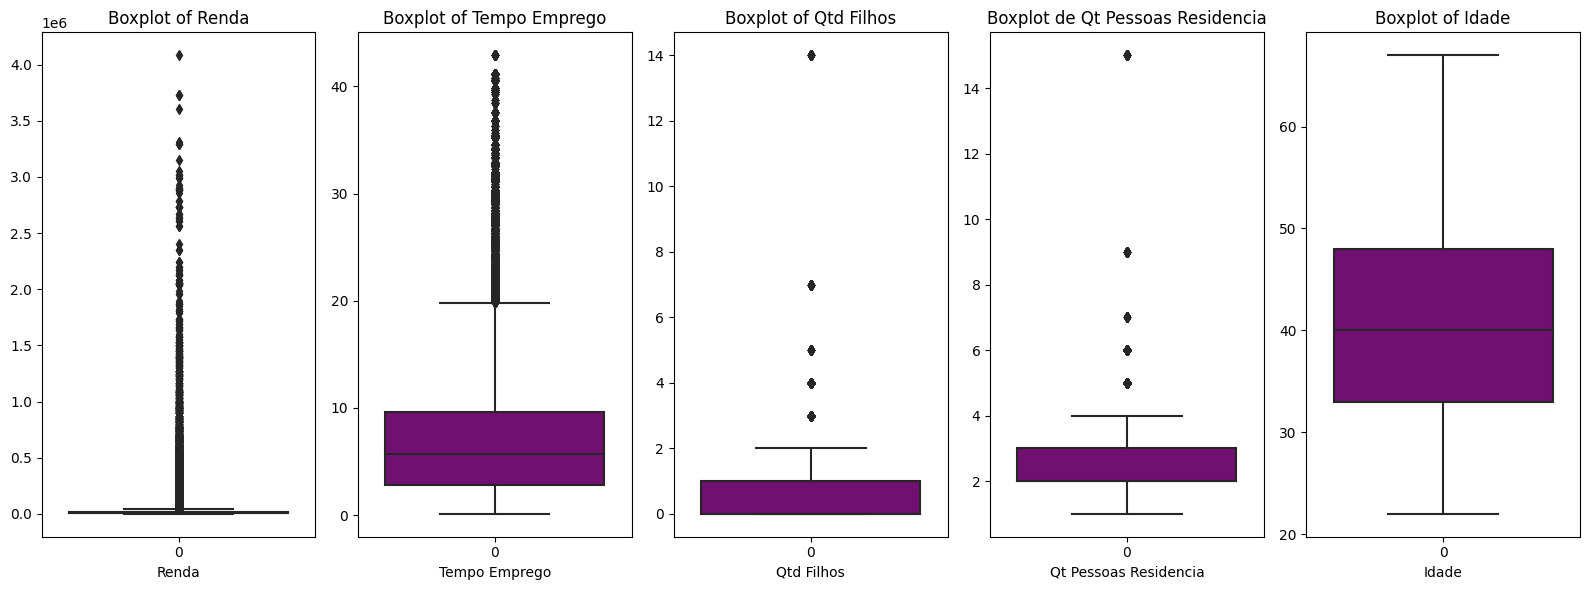

In [7]:
# Set the color you want (e.g., 'purple')
box_color = 'purple'

# Create a figure with four subplots
plt.figure(figsize=(16, 6))

# First subplot for 'renda'
plt.subplot(1, 5, 1)
sns.boxplot(data['renda'], color=box_color)
plt.title('Boxplot of Renda')
plt.xlabel('Renda')

# Second subplot for 'tempo_emprego'
plt.subplot(1, 5, 2)
sns.boxplot(data['tempo_emprego'], color=box_color)
plt.title('Boxplot of Tempo Emprego')
plt.xlabel('Tempo Emprego')

# Third subplot for 'qtd_filhos'
plt.subplot(1, 5, 3)
sns.boxplot(data['qtd_filhos'], color=box_color)
plt.title('Boxplot of Qtd Filhos')
plt.xlabel('Qtd Filhos')

# Fourth subplot for 'qt_pessoas_residencia'
plt.subplot(1, 5, 4)
sns.boxplot(data['qt_pessoas_residencia'], color=box_color)
plt.title('Boxplot de Qt Pessoas Residencia')
plt.xlabel('Qt Pessoas Residencia')

# Fith subplot for 'idade'
plt.subplot(1, 5, 5)
sns.boxplot(data['idade'], color=box_color)
plt.title('Boxplot of Idade')
plt.xlabel('Idade')

# Adjust layout
plt.tight_layout()
# Show the plots
plt.show()

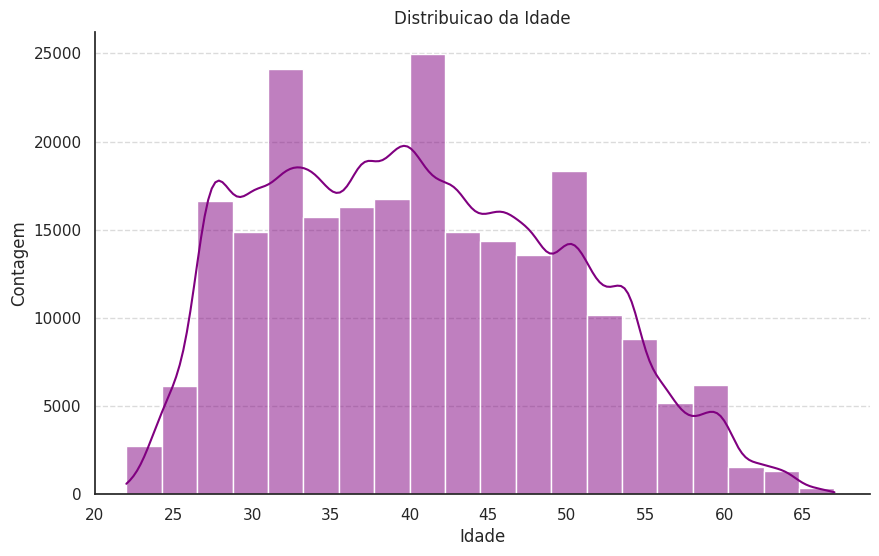

In [8]:
# Set the color you want (e.g., 'blue')
hist_color = 'purple'

# Set seaborn style
sns.set(style='white')

# Create a histogram using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data['idade'], color=hist_color, bins=20, kde=True)  # With KDE for a smoothed line
plt.title('Distribuicao da Idade')
plt.xlabel('Idade')
plt.ylabel('Contagem')
plt.xticks(range(0, max(data['idade']) + 1, 5))  # Customize x-axis ticks

# Add grid and remove right and top spines
sns.despine()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xlim(20,)

# Show the plot
plt.tight_layout
plt.show()

### Amostragem

In [9]:
# Get the maximum date in the dataset
max_date = data['data_ref'].max()

# Calculate the start date for the last three months
start_date = max_date - pd.DateOffset(months=3)

# Filter the data for the last three months
# Validation out of time (oot)
data_oot = data[(data['data_ref'] >= start_date) & (data['data_ref'] <= max_date)]

# Filter the rows to be removed (last three months data)
rows_to_remove = data[(data['data_ref'] >= start_date) & (data['data_ref'] <= max_date)].index

# Remove the rows from the original dataset
data_cleaned = data.drop(rows_to_remove)

# 2. Data Exploration

### Descritiva básica univariada

In [10]:
# Get the count of rows for each month in 'data_ref'
monthly_counts = data_cleaned['data_ref'].dt.to_period('M').value_counts().sort_index()

# Define a list of month names
month_names = ["Jan", "Fev", "Mar", "Abr", "Mai", "Jun", "Jul", "Ago", "Set", "Out", "Nov"]

# Print the number of rows for each month
print("Numero de registros para cada mes:")
for period, count in monthly_counts.items():
    print(f"{month_names[period.month - 1]} {period.year}: {count}")

Numero de registros para cada mes:
Jan 2015: 16623
Fev 2015: 16104
Mar 2015: 15560
Abr 2015: 14933
Mai 2015: 14471
Jun 2015: 14234
Jul 2015: 14143
Ago 2015: 14225
Set 2015: 14483
Out 2015: 14904
Nov 2015: 15617


### Variaveis Qualitativas

In [11]:
# Basic univariate analysis for quantitative variables
quantitative_vars = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

#### Tempo de emprego

In [12]:
data.tempo_emprego.describe()

count    232730.000000
mean          7.326544
std           6.424824
min           0.117808
25%           2.794521
50%           5.676712
75%           9.610959
max          42.906849
Name: tempo_emprego, dtype: float64

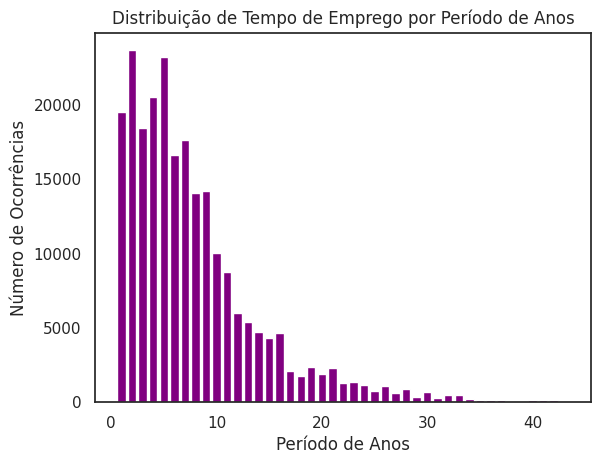

In [13]:
# Arredondar os valores para obter os períodos de anos
data['tempo_emprego_anos'] = data['tempo_emprego'].dropna().apply(lambda x: math.ceil(x))

# Contar o número de ocorrências em cada período de anos
period_counts = data['tempo_emprego_anos'].value_counts().sort_index()

# Plotar um gráfico de barras dos períodos de anos
plt.bar(period_counts.index, period_counts.values, color = 'purple')
plt.xlabel('Período de Anos')
plt.ylabel('Número de Ocorrências')
plt.title('Distribuição de Tempo de Emprego por Período de Anos')
plt.show()

A análise da variável "tempo_emprego" revela uma distribuição que sugere um padrão claro na experiência dos trabalhadores. A grande maioria dos indivíduos apresenta uma faixa de tempo de emprego entre 0 e 10 anos, indicando que a maioria dos profissionais está relativamente no início de suas carreiras. Isso pode ser associado a uma possível rotatividade de pessoal ou a um mercado de trabalho que frequentemente recebe novos profissionais. Por outro lado, uma observação notável é que há poucos trabalhadores que acumularam mais de 20 anos de experiência. Esse grupo pode representar profissionais mais experientes e talvez sejam os líderes ou especialistas em suas áreas, cuja experiência prolongada pode ser altamente valorizada por suas organizações. A disparidade entre essas duas categorias sugere uma distribuição assimétrica, com um pico na faixa mais baixa e uma cauda longa na faixa mais alta, o que pode influenciar a dinâmica do mercado de trabalho e as oportunidades de crescimento profissional.

#### Renda

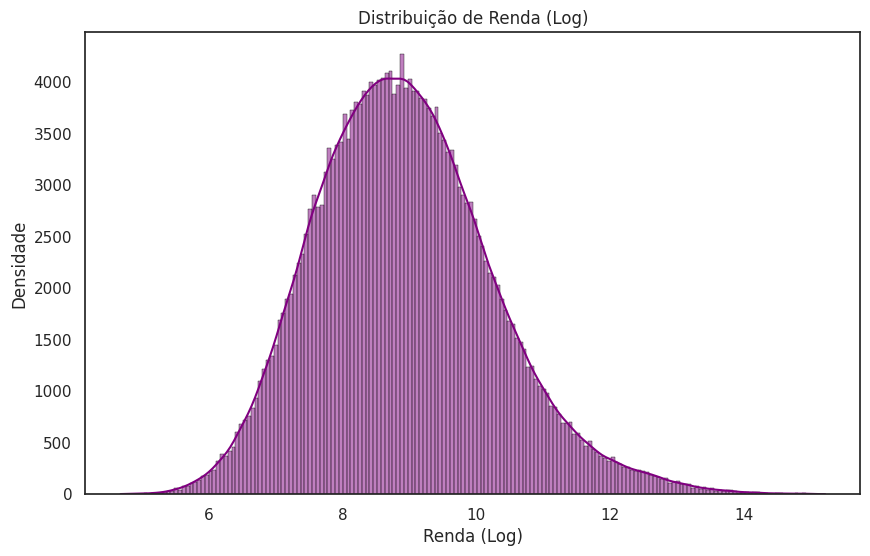

In [14]:
# Aplicar transformação logarítmica à variável de renda
data['renda_log'] = np.log(data['renda'])

plt.figure(figsize=(10, 6))
sns.histplot(data['renda_log'], kde=True, color='purple', edgecolor='black')
plt.xlabel('Renda (Log)')
plt.ylabel('Densidade')
plt.title('Distribuição de Renda (Log)')

plt.show()

A análise da distribuição da renda, após a aplicação da transformação logarítmica, revela uma característica simétrica notável. A curva de densidade exibe uma forma equilibrada, com um pico pronunciado ocorrendo em torno de $8000,00. Essa simetria sugere que os valores de renda estão distribuídos uniformemente em ambos os lados da média, o que pode ser indicativo de uma distribuição mais balanceada em termos de distribuição de renda. No entanto, é importante notar que, apesar da simetria central, a distribuição possui uma cauda longa que se estende além de $1200000,00. Isso implica que existem valores de renda relativamente raros ou atípicos, que se afastam consideravelmente da maioria dos dados. Essa cauda estendida pode indicar a presença de indivíduos ou famílias com rendimentos substancialmente elevados, o que contribui para uma maior variabilidade na distribuição.

### Variaveis Quantitivas

In [15]:
# Basic univariate analysis for categorical variables
categorical_vars = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'mau']

In [16]:
def plot_descricao_univariada(feature: str):
    # Personalizar paleta de cores
    colors = ["#66b3ff", "#99ff99"]

    plt.figure(figsize=(8, 6))
    sns.countplot(x=feature, data=data, palette=colors)
    plt.xlabel('')
    plt.ylabel('Frequência')
    plt.title(f'Distribuição da Variável {feature}')
    # Rotacionar rótulos do eixo x para melhor visualização
    plt.xticks(rotation=45, ha='right')

    # Adicionar porcentagens nas barras
    total = len(data[feature])
    for p in plt.gca().patches:
        height = p.get_height()
        plt.text(p.get_x() + p.get_width() / 2, height + 3, f'{height/total:.1%}', ha="center")

    # Ajustar layout
    plt.tight_layout()
    plt.show()

#### Sexo

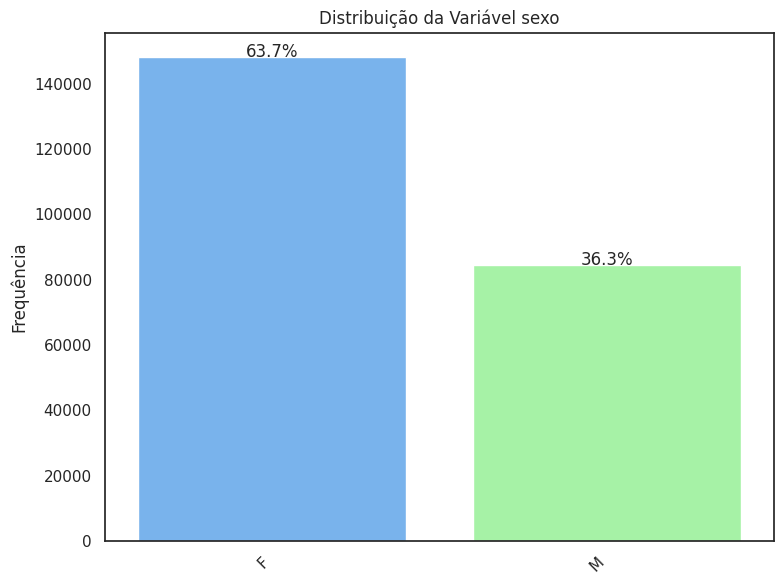

In [17]:
plot_descricao_univariada('sexo')

#### Posse de Veiculo

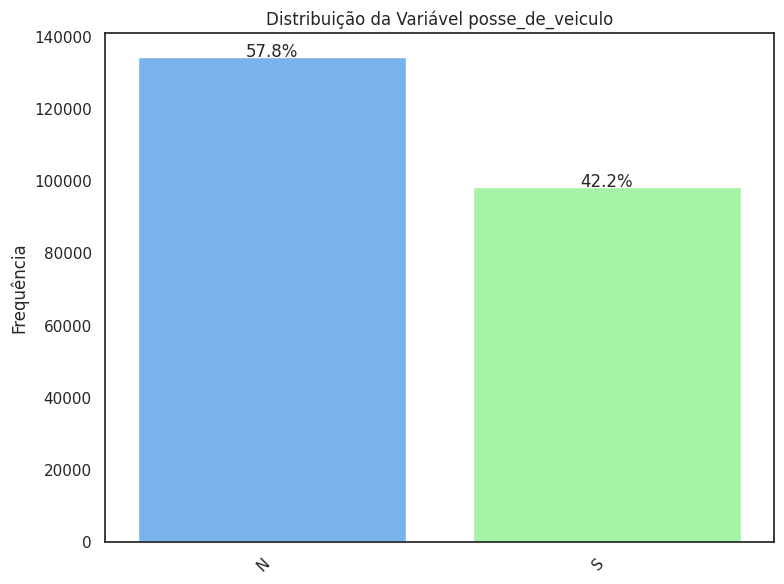

In [18]:
plot_descricao_univariada('posse_de_veiculo')

#### Posse de Imovel

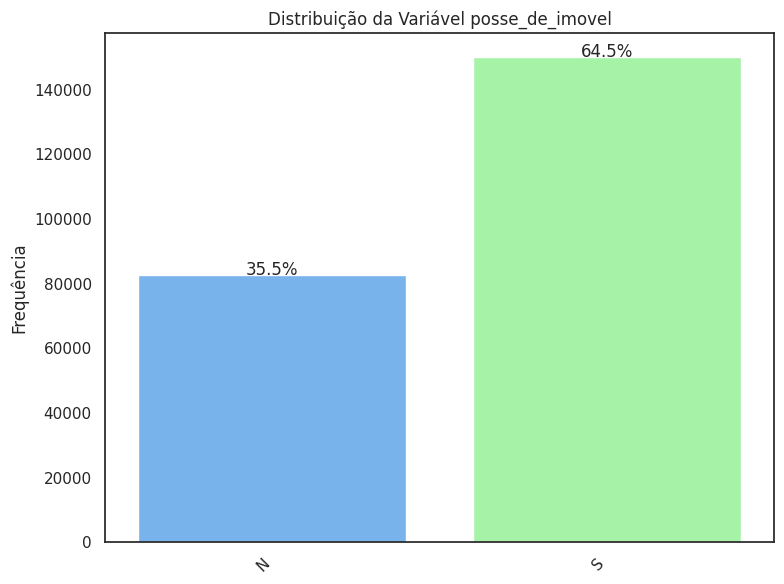

In [19]:
plot_descricao_univariada('posse_de_imovel')

#### Tipo de Renda

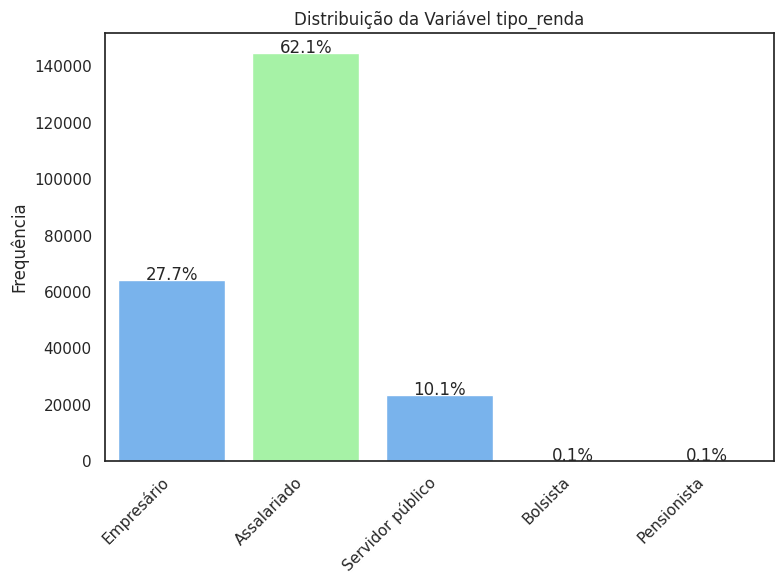

In [20]:
plot_descricao_univariada('tipo_renda')

#### Educação

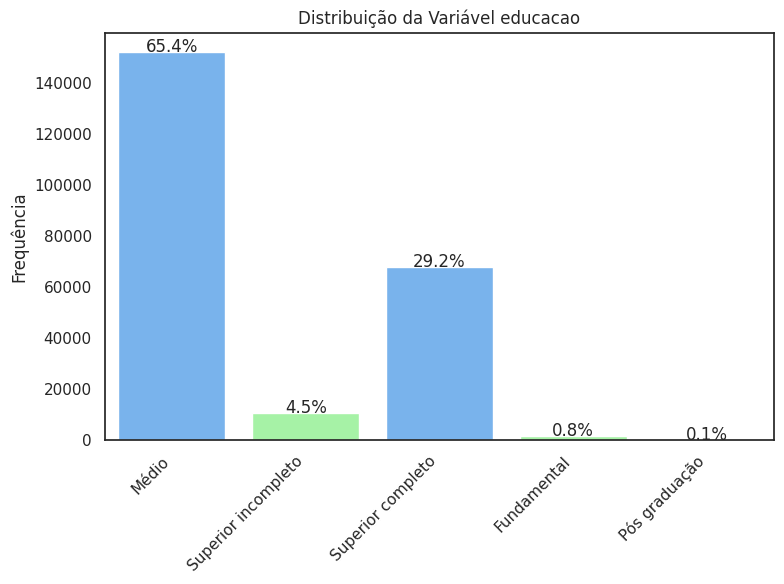

In [21]:
plot_descricao_univariada('educacao')

#### Estado Civil

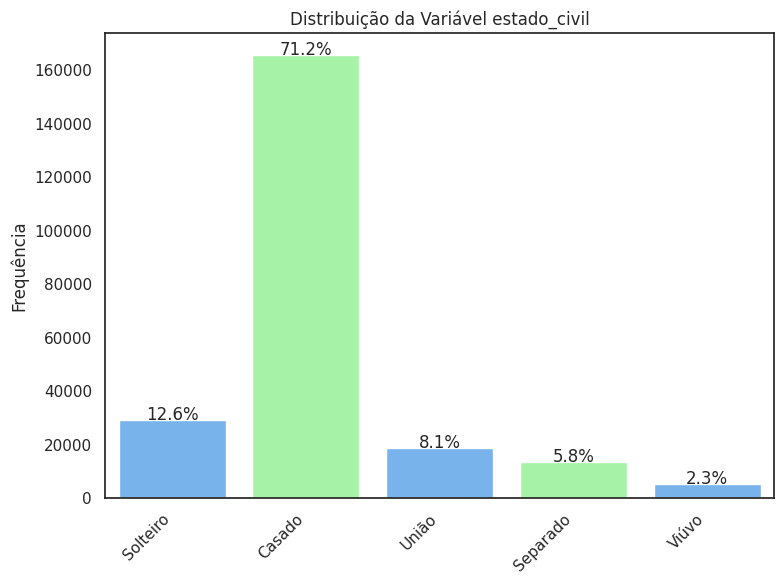

In [22]:
plot_descricao_univariada('estado_civil')

#### Tipo de Residencia

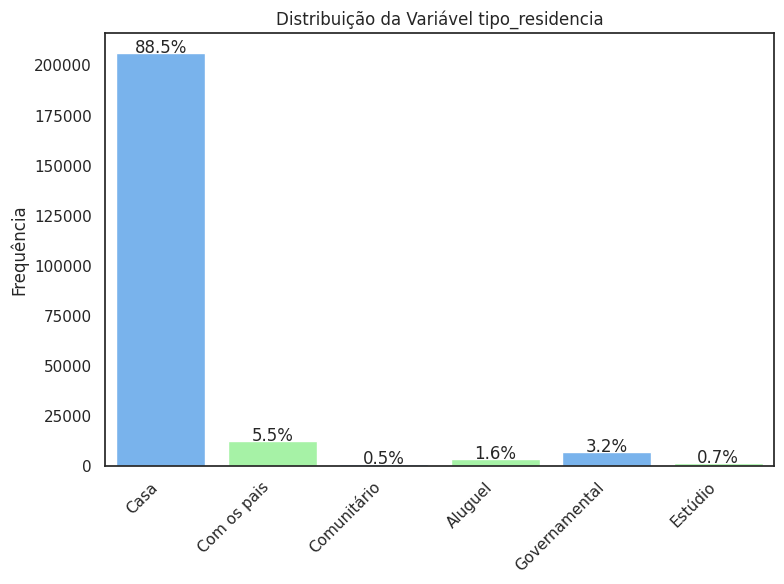

In [23]:
plot_descricao_univariada('tipo_residencia')

### Perfil Demográfico e Socioeconômico do Grupo

O panorama desse grupo de pessoas revela um perfil diversificado. Aqui estão algumas das principais características:

- **Idade Média:** A média de idade é de 43 anos, indicando uma ampla distribuição etária.

- **Renda Média:** A média de renda é de 8 mil reais, abrangendo uma faixa variada de situações financeiras.

- **Sexo:** A maioria é do sexo feminino, representando 67% do grupo, enquanto os homens compõem os 33% restantes.

- **Mobilidade:** É notável que 61% do grupo escolheu não possuir um veículo, refletindo uma opção consciente em relação à mobilidade.

- **Habitação:** Cerca de um terço do grupo (33.4%) não possui imóvel próprio, indicando diversidade nas opções de residência.

- **Educação:** A predominância de pessoas com ensino médio (67%) sugere um nível educacional intermediário.

- **Estado Civil:** A maioria é casada, representando 70% do grupo, destacando a relevância das relações familiares.

Essa combinação de características revela a diversidade e dinâmica desse grupo, refletindo estágios de vida distintos, escolhas financeiras e pessoais variadas.



### Descritiva Bivariada

#### Posse de veiculo vs Posse de Imovel

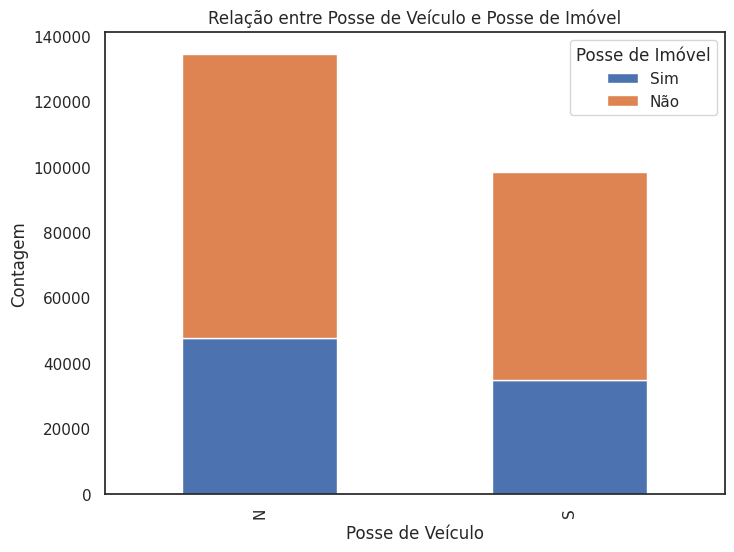

In [24]:

# Contar a frequência de cada combinação
cross_tab = pd.crosstab(data['posse_de_veiculo'], data['posse_de_imovel'])

# Criar o gráfico de barras empilhadas
cross_tab.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.xlabel('Posse de Veículo')
plt.ylabel('Contagem')
plt.title('Relação entre Posse de Veículo e Posse de Imóvel')
plt.legend(title='Posse de Imóvel', labels=['Sim', 'Não'])

plt.show()

#### Idade vs Numero de Filhos

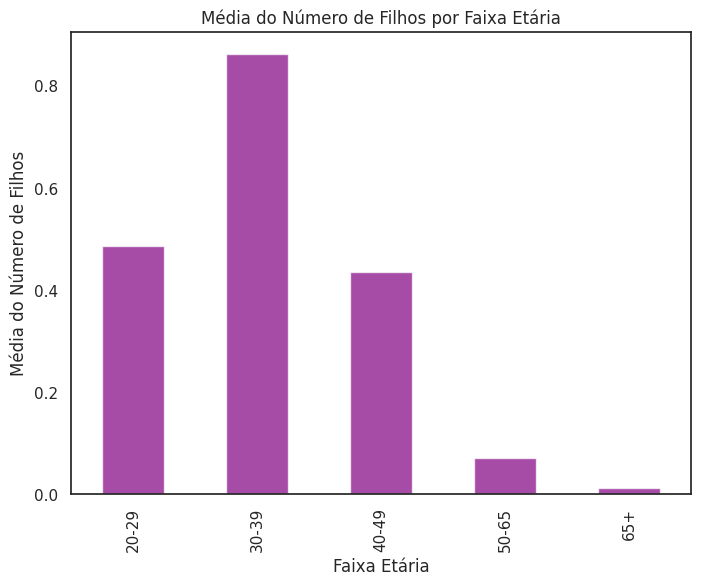

In [25]:

# Criar faixas etárias para agrupar as idades
faixas_etarias = ['20-29', '30-39', '40-49', '50-65', '65+']
data['faixa_etaria'] = pd.cut(data['idade'], bins=[20, 29, 39, 49, 59, 100], labels=faixas_etarias)

# Calcular a média do número de filhos por faixa etária
media_filhos_por_faixa = data.groupby('faixa_etaria')['qtd_filhos'].mean()

# Criar o gráfico de barras
plt.figure(figsize=(8, 6))
media_filhos_por_faixa.plot(kind='bar', color='purple', alpha=0.7)
plt.xlabel('Faixa Etária')
plt.ylabel('Média do Número de Filhos')
plt.title('Média do Número de Filhos por Faixa Etária')

plt.show()

#### Educação vs. Renda

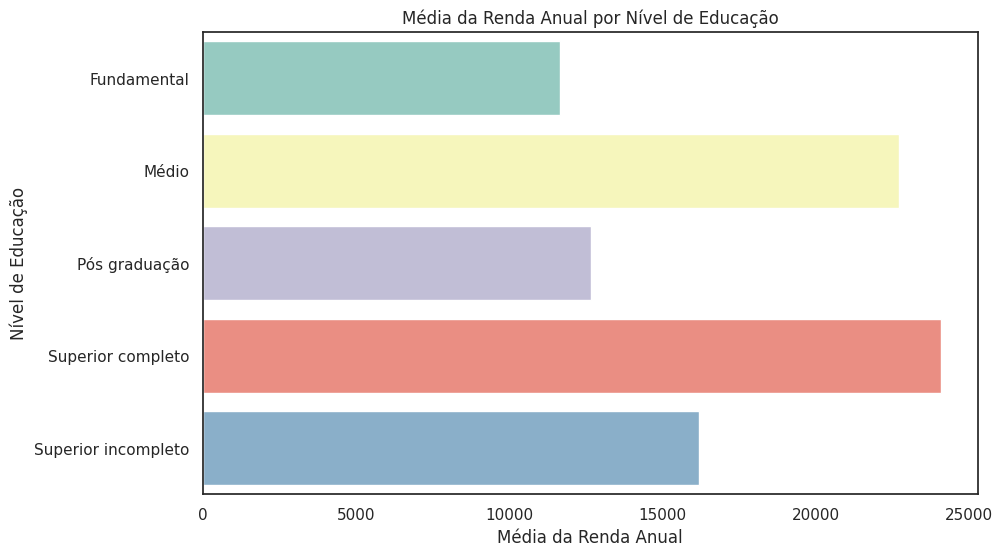

In [26]:
# Calcular a média da renda por nível de educação
media_renda_por_educacao = data.groupby('educacao')['renda'].mean().reset_index()

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='renda', y='educacao', data=media_renda_por_educacao, palette='Set3')
plt.xlabel('Média da Renda Anual')
plt.ylabel('Nível de Educação')
plt.title('Média da Renda Anual por Nível de Educação')

plt.show()

#### Tipo de Renda vs. Tempo de Emprego


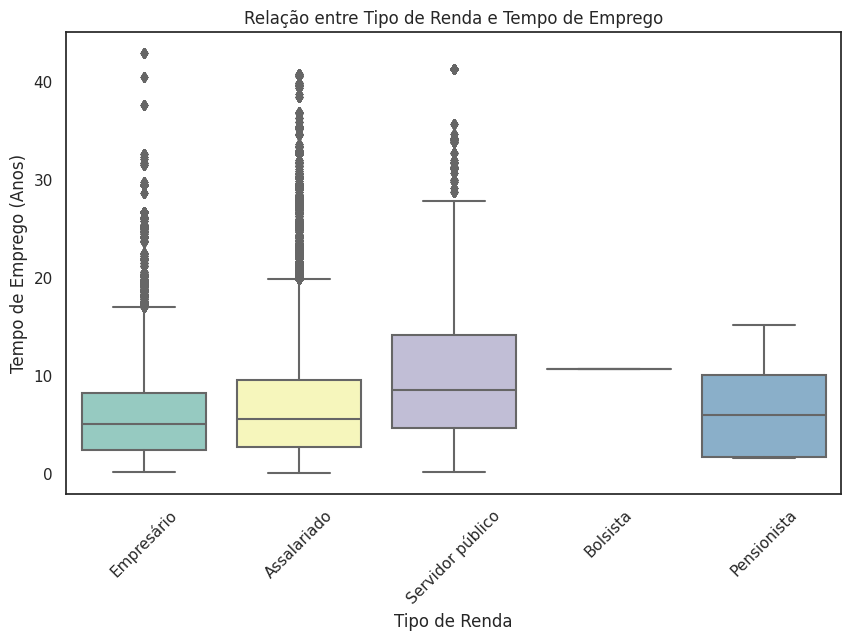

In [27]:
# Criar o gráfico de caixa
plt.figure(figsize=(10, 6))
sns.boxplot(x='tipo_renda', y='tempo_emprego', data=data, palette='Set3')
plt.xlabel('Tipo de Renda')
plt.ylabel('Tempo de Emprego (Anos)')
plt.title('Relação entre Tipo de Renda e Tempo de Emprego')

plt.xticks(rotation=45)

plt.show()

#### Renda vs. Posse de Imóvel

<Figure size 1000x600 with 0 Axes>

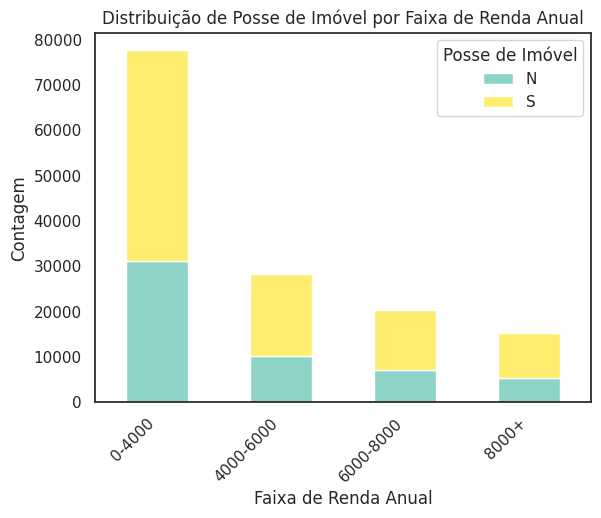

In [28]:
# Definir faixas de renda para categorizar os dados
faixas_renda = [0, 4000, 6000, 8000, 10000]
categorias_renda = ['0-4000', '4000-6000', '6000-8000', '8000+']

# Categorizar os dados de renda
data['faixa_renda'] = pd.cut(data['renda'], bins=faixas_renda, labels=categorias_renda)

# Criar uma tabela cruzada para contar a posse de imóvel em cada faixa de renda
tabela_cruzada = pd.crosstab(data['faixa_renda'], data['posse_de_imovel'])

# Criar o gráfico de barras empilhadas
plt.figure(figsize=(10, 6))
tabela_cruzada.plot(kind='bar', stacked=True, colormap='Set3')
plt.xlabel('Faixa de Renda Anual')
# Rotacionar rótulos do eixo x para melhor visualização
plt.xticks(rotation=45, ha='right')
plt.ylabel('Contagem')
plt.title('Distribuição de Posse de Imóvel por Faixa de Renda Anual')
plt.legend(title='Posse de Imóvel', loc='upper right')

plt.show()

#### Tempo de Emprego vs. Idade

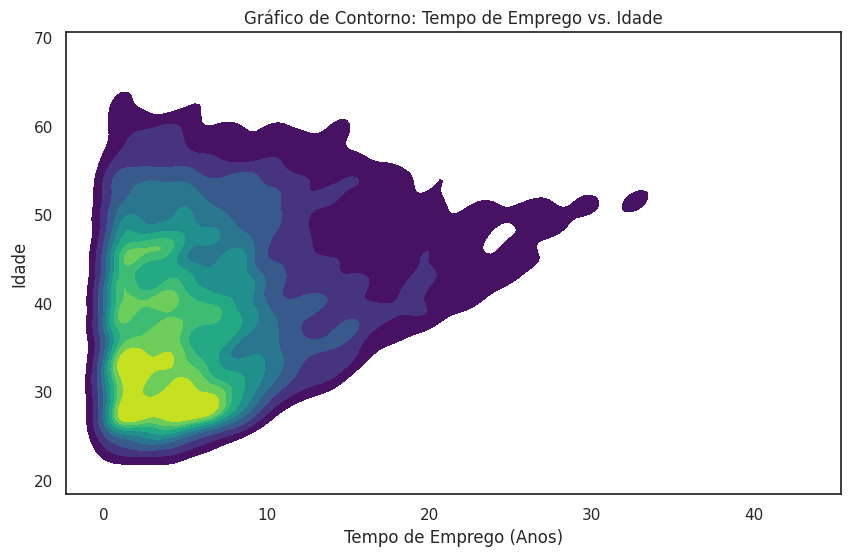

In [29]:
# Criar o gráfico de contorno
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data, x='tempo_emprego', y='idade', cmap='viridis', fill=True)
plt.xlabel('Tempo de Emprego (Anos)')
plt.ylabel('Idade')
plt.title('Gráfico de Contorno: Tempo de Emprego vs. Idade')
plt.show()

As cores mais claras são de maior incidência.

#### Idade, Tempo de Emprego e Renda

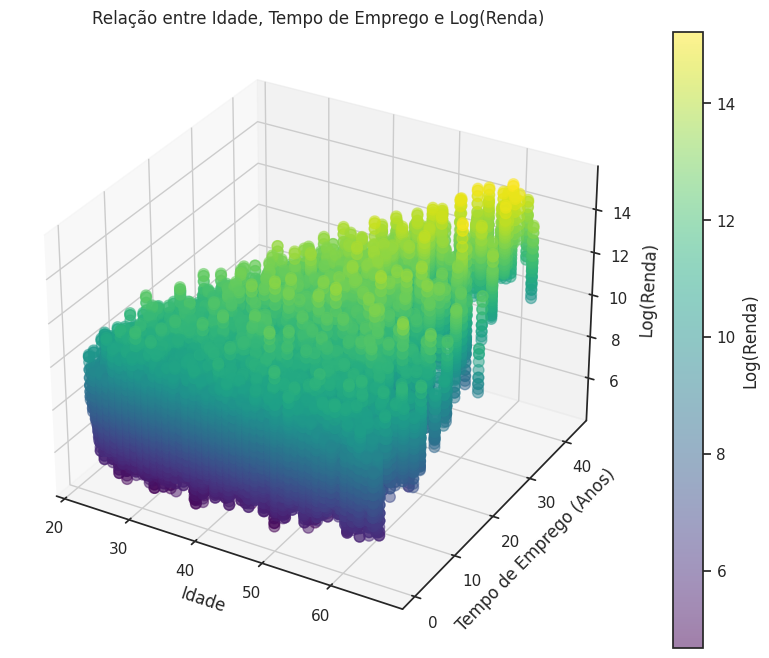

In [30]:
# Calcular o logaritmo da renda
data['log_renda'] = np.log(data['renda'])

# Criar o gráfico de dispersão 3D com o logaritmo da renda
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Configurar as cores, marcadores e opacidade dos pontos
scatter = ax.scatter(data['idade'], data['tempo_emprego'], data['log_renda'], c=data['log_renda'], cmap='viridis', marker='o', alpha=0.5, s=60)

# Adicionar uma barra de cores para representar a escala do logaritmo da renda
cbar = fig.colorbar(scatter)
cbar.set_label('Log(Renda)')

ax.set_xlabel('Idade')
ax.set_ylabel('Tempo de Emprego (Anos)')
ax.set_zlabel('Log(Renda)')
ax.set_title('Relação entre Idade, Tempo de Emprego e Log(Renda)')

plt.show()

#### Analise Relacional das Variaveis.

# 3. Data Modeling

In [31]:
data_cleaned.drop(columns='data_ref', inplace=True)
renda = data_cleaned['renda']

#### Ordinal Mapping

In [168]:
data_encoded = data_cleaned.copy()

In [169]:
# Calculate the logarithm of the 'renda' column
# data_encoded['log_renda'] = np.log(data_encoded['renda'] + 1.001)  # Adding 1 to avoid logarithm of zero

In [170]:
ordinal_mappings = {
    'sexo': {'F': 0, 'M': 1},
    'posse_de_veiculo': {'N': 0, 'S': 1},
    'posse_de_imovel': {'N': 0, 'S': 1},
    'tipo_renda': {
        'Empresário': 0,
        'Assalariado': 1,
        'Servidor público': 2,
        'Bolsista': 3,
        'Pensionista': 4
    },
    'educacao': {
        'Fundamental': 0,
        'Médio': 1,
        'Superior incompleto': 2,
        'Superior completo': 3,
        'Pós graduação': 4
    },
    'estado_civil': {
        'Solteiro': 0,
        'Casado': 1,
        'União': 2,
        'Separado': 3,
        'Viúvo': 4
    },
    'tipo_residencia': {
        'Aluguel': 0,
        'Com os pais': 1,
        'Comunitário': 2,
        'Casa': 3,
        'Estúdio': 4,
        'Governamental': 5
    },
    'mau': {
        False: 0,
        True: 1
    }
}


In [171]:
# Apply ordinal encoding to the specified columns
for column, mapping in ordinal_mappings.items():
    data_encoded[column + '_encoded'] = data_encoded[column].map(mapping)

# Drop the original categorical columns
data_encoded.drop(columns=list(ordinal_mappings.keys()), inplace=True)

#### Categorizando as variaveis numericas

In [172]:
data_encoded.head()

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,sexo_encoded,posse_de_veiculo_encoded,posse_de_imovel_encoded,tipo_renda_encoded,educacao_encoded,estado_civil_encoded,tipo_residencia_encoded,mau_encoded
0,0,43,6.873973,1.0,2515.39,0,0,0,0,1,0,3,0
1,0,35,4.526027,2.0,3180.19,0,1,1,1,1,1,3,0
2,2,31,0.243836,4.0,1582.29,0,0,0,1,1,1,3,0
3,0,54,12.772603,2.0,13721.17,0,0,0,1,1,1,3,0
4,0,31,8.432877,1.0,2891.08,0,1,0,1,2,0,3,0


In [173]:
# Define the bin edges for numerical columns
bin_edges = {
    'idade': [20, 30, 40, 50, 60, 70],
    'tempo_emprego': [0, 0.5, 1, 2, 5, 10, 15, 20, 25, 30, 35, 40, 45],
    'qt_pessoas_residencia': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    # 'log_renda': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
}

# Apply pd.cut() to create categorical bins for numerical columns
for column, edges in bin_edges.items():
    data_encoded[column + '_category'] = pd.cut(data_encoded[column], bins=edges, labels=False)

# Excluindo oa colunas originais
data_encoded.drop(columns=list(bin_edges.keys()), inplace=True)
data_encoded.drop(columns='renda', inplace=True)

In [174]:
data_encoded.head()

,qtd_filhos,sexo_encoded,posse_de_veiculo_encoded,posse_de_imovel_encoded,tipo_renda_encoded,educacao_encoded,estado_civil_encoded,tipo_residencia_encoded,mau_encoded,idade_category,tempo_emprego_category,qt_pessoas_residencia_category
0,0,0,0,0,0,1,0,3,0,2,4,0
1,0,0,1,1,1,1,1,3,0,1,3,1
2,2,0,0,0,1,1,1,3,0,1,0,3
3,0,0,0,0,1,1,1,3,0,3,5,1
4,0,0,1,0,1,2,0,3,0,1,4,0


#### Regressão logística

In [177]:
data_encoded.columns

Index(['qtd_filhos', 'sexo_encoded', 'posse_de_veiculo_encoded',
       'posse_de_imovel_encoded', 'tipo_renda_encoded', 'educacao_encoded',
       'estado_civil_encoded', 'tipo_residencia_encoded', 'mau',
       'idade_category', 'tempo_emprego_category',
       'qt_pessoas_residencia_category'],
      dtype='object')

In [175]:
data_encoded.rename(columns={"mau_encoded": "mau"}, inplace=True)

In [176]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Split the dataset into features (X) and target (y)
X = data_encoded[['qtd_filhos', 'sexo_encoded', 'posse_de_veiculo_encoded', 'posse_de_imovel_encoded', 'tipo_renda_encoded', 'educacao_encoded', 'estado_civil_encoded', 'tipo_residencia_encoded', 'idade_category', 'tempo_emprego_category', 'qt_pessoas_residencia_category', 'renda']]
y = data_encoded['mau']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (important for logistic regression)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create a logistic regression model
model = LogisticRegression(random_state=42, penalty='elasticnet', solver='saga', l1_ratio=0.60)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)



KeyError: "['renda'] not in index"